In [1]:
!pip install git+https://github.com/adil3319/jim_v1
#!pip install jimGW

  Cloning https://github.com/adil3319/jim_v1 to /tmp/pip-req-build-wh0ox_lm
  Running command git clone --filter=blob:none --quiet https://github.com/adil3319/jim_v1 /tmp/pip-req-build-wh0ox_lm
  Resolved https://github.com/adil3319/jim_v1 to commit fb6066ba81cf8ca971ebd65ea5cd76fce1b1cda9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of flowmc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of equinox to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of evosax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of flax to determine which version is compatible with other requirements. This could take a while.
INF

In [2]:
# For CUDA 12 with cuDNN 8.9
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.1
    Uninstalling jax-cuda12-pjrt-0.5.1:
      Successfully uninstalled jax-cuda12-pjrt-0.5.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.

In [3]:
!pip install --upgrade equinox

  Using cached equinox-0.12.2-py3-none-any.whl.metadata (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: equinox
    Found existing installation: equinox 0.11.10
    Uninstalling equinox-0.11.10:
      Successfully uninstalled equinox-0.11.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jimgw 0.2.0 requires jax<=0.4.31,>=0.4.24, but you have jax 0.6.1 which is incompatible.


In [4]:
import numpy as np
import jax.numpy as jnp

In [5]:
import time

import jax
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

from jimgw.jim import Jim
from jimgw.prior import *
#from jimgw.jim import Jim
# from jimgw.prior import (
#     CombinePrior,
#     UniformPrior,
#     CosinePrior,
#     SinePrior,
#     PowerLawPrior,
#     UniformSpherePrior,
# )
from jimgw.single_event.detector import H1, L1, V1
from jimgw.single_event.likelihood import TransientLikelihoodFD, HeterodynedTransientLikelihoodFD
from jimgw.single_event.waveform import RippleIMRPhenomD,RippleIMRPhenomD_NRTidalv2,RippleTaylorF2, RippleIMRPhenomD_ScalarTensor
from jimgw.transforms import BoundToUnbound
from jimgw.single_event.transforms import (
    SkyFrameToDetectorFrameSkyPositionTransform,
    SphereSpinToCartesianSpinTransform,
    MassRatioToSymmetricMassRatioTransform,
    DistanceToSNRWeightedDistanceTransform,
    GeocentricArrivalTimeToDetectorArrivalTimeTransform,
    GeocentricArrivalPhaseToDetectorArrivalPhaseTransform,
)
from jimgw.single_event.utils import Mc_q_to_m1_m2
from flowMC.strategy.optimization import optimization_Adam

jax.config.update("jax_enable_x64", True)

###########################################
########## First we grab data #############
###########################################

total_time_start = time.time()

# first, fetch a 4s segment centered on GW150914

ifos = [H1, L1, V1]


# tukey_alpha = 2 / (duration / 2)
# H1.load_data(
#     gps, duration, 2, fmin, fmax, psd_pad=duration + 16, tukey_alpha=tukey_alpha
# )
# L1.load_data(
#     gps, duration, 2, fmin, fmax, psd_pad=duration + 16, tukey_alpha=tukey_alpha
# )
# V1.load_data(
#     gps, duration, 2, fmin, fmax, psd_pad=duration + 16, tukey_alpha=tukey_alpha
# )

H1.frequencies = np.genfromtxt('H1_freq.txt')
H1_data_re, H1_data_im = np.genfromtxt('H1_data_re.txt'), np.genfromtxt('H1_data_im.txt')
H1.data = H1_data_re + 1j * H1_data_im
H1_jnp = jax.numpy.array(H1.frequencies)

L1.frequencies = np.genfromtxt('L1_freq.txt')
L1_data_re, L1_data_im = np.genfromtxt('L1_data_re.txt'), np.genfromtxt('L1_data_im.txt')
L1.data = L1_data_re + 1j * L1_data_im
L1_jnp = jax.numpy.array(L1.frequencies)

V1.frequencies = np.genfromtxt('V1_freq.txt')
V1_data_re, V1_data_im = np.genfromtxt('V1_data_re.txt'), np.genfromtxt('V1_data_im.txt')
V1.data = V1_data_re + 1j * V1_data_im
V1_jnp = jax.numpy.array(V1.frequencies)
# Load the PSD

H1.psd = H1.load_psd(H1_jnp, psd_file ="GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_H1_psd.txt")
L1.psd = L1.load_psd(L1_jnp, psd_file = "GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_L1_psd.txt")
V1.psd = V1.load_psd(V1_jnp, psd_file = "GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_V1_psd.txt")





In [6]:
len(H1.data),len(H1.psd),len(H1.frequencies),len(L1.psd),len(L1.frequencies),len(V1.psd),len(V1.frequencies)

(259583, 259583, 259583, 259583, 259583, 259583, 259583)

In [7]:
import numpy as np

# H1 frequency masking
ah = H1.frequencies
bh = H1.data
ch = H1.psd

# Find the indices where any of the arrays contains inf
mask = np.isinf(ah) | np.isinf(bh) | np.isinf(ch)

# Remove the elements where the mask is True
H1.frequencies = ah[~mask][:-1]
H1.data = bh[~mask][:-1]
H1.psd = ch[~mask][:-1]



# L1 frequency masking
aL = L1.frequencies
bL = L1.data
cL = L1.psd

# Find the indices where any of the arrays contains inf
mask = np.isinf(aL) | np.isinf(bL) | np.isinf(cL)

# Remove the elements where the mask is True
L1.frequencies = aL[~mask]
L1.data = bL[~mask]
L1.psd = cL[~mask]


# V1 frequency masking
aV = V1.frequencies
bV = V1.data
cV = V1.psd

# Find the indices where any of the arrays contains inf
mask = np.isinf(aV) | np.isinf(bV) | np.isinf(cV)

# Remove the elements where the mask is True
V1.frequencies = aV[~mask]
V1.data = bV[~mask]
V1.psd = cV[~mask]





gps = 1187008882.43
trigger_time = gps
fmin = min(H1.frequencies)
fmax = max(H1.frequencies)
#fmax = 2048
minimum_frequency = fmin
maximum_frequency = fmax
duration = 128
post_trigger_duration = 2
epoch = duration - post_trigger_duration
f_ref = fmin

waveform = RippleIMRPhenomD_ScalarTensor(f_ref=f_ref)
#RippleIMRPhenomD_NRTidalv2(f_ref=f_ref)


In [8]:
len(H1.data),len(H1.psd),len(H1.frequencies),len(L1.psd),len(L1.frequencies),len(V1.psd),len(V1.frequencies)

(259199, 259199, 259199, 259199, 259199, 259199, 259199)

In [9]:
min(H1.frequencies),min(L1.frequencies),min(V1.frequencies),max(H1.frequencies),max(L1.frequencies),max(V1.frequencies)

(np.float64(23.0),
 np.float64(23.0),
 np.float64(23.0),
 np.float64(2047.984375),
 np.float64(2047.984375),
 np.float64(2047.984375))

In [10]:
fmin,fmax

(np.float64(23.0), np.float64(2047.984375))

In [11]:
import numpy as np

# Example array


# Check if there are any inf values in a
contains_inf = np.any(np.isinf(H1.psd))

if contains_inf:
    print("Array contains inf values.")
else:
    print("Array does not contain inf values.")


Array does not contain inf values.


In [12]:
@jaxtyped(typechecker=typechecker)
class GaussianPrior(Prior):
    """
    A prior distribution based on a Gaussian (Normal) distribution with arbitrary mu and sigma.

    The probability density function (pdf) of a Gaussian is:
    p(x) = (1 / (sigma * sqrt(2 * pi))) * exp(-(x - mu)^2 / (2 * sigma^2))

    Parameters
    ----------
    mu : float
        The mean of the Gaussian distribution.
    sigma : float
        The standard deviation of the Gaussian distribution.
    parameter_names : list[str]
        A list of names for the parameters of the prior.
    """

    mu: float
    sigma: float

    def __repr__(self):
        return f"GaussianPrior(mu={self.mu}, sigma={self.sigma}, parameter_names={self.parameter_names})"

    def __init__(self, mu: float, sigma: float, parameter_names: list[str]):
        super().__init__(parameter_names)
        assert self.n_dim == 1, "GaussianPrior needs to be 1D distributions"
        self.mu = mu
        self.sigma = sigma

    def sample(
        self, rng_key: PRNGKeyArray, n_samples: int
    ) -> dict[str, Float[Array, " n_samples"]]:
        """
        Sample from the Gaussian distribution.

        Parameters
        ----------
        rng_key : PRNGKeyArray
            A random key to use for sampling.
        n_samples : int
            The number of samples to draw.

        Returns
        -------
        samples : dict
            Samples from the distribution. The keys are the names of the parameters.

        """
        samples = jax.random.normal(rng_key, (n_samples,)) * self.sigma + self.mu
        return self.add_name(samples[None])

    def log_prob(self, z: dict[str, Float]) -> Float:
        """
        Calculate the log-probability of the Gaussian distribution at a given value.

        Parameters
        ----------
        z : dict[str, Float]
            A dictionary of parameter values (with parameter names as keys).

        Returns
        -------
        log_prob : float
            The log-probability of the value according to the Gaussian distribution.
        """
        variable = z[self.parameter_names[0]]
        return -0.5 * ((variable - self.mu) ** 2) / (self.sigma ** 2) - 0.5 * jnp.log(2 * jnp.pi * self.sigma ** 2)


In [13]:
###########################################
########## Set up priors ##################
###########################################
import time
t1 = time.time()
prior = []

# Mass prior
M_c_min, M_c_max = 1.18, 1.21
q_min, q_max = 0.125, 1.0
Mc_prior = UniformPrior(M_c_min, M_c_max, parameter_names=["M_c"])
q_prior = UniformPrior(q_min, q_max, parameter_names=["q"])

prior = prior + [Mc_prior, q_prior]

# Spin prior
s1_prior = UniformPrior(-0.05, 0.05, parameter_names=["s1_z"])
s2_prior = UniformPrior(-0.05, 0.05, parameter_names=["s2_z"])
iota_prior = GaussianPrior(2.85,0.03,parameter_names=["iota"])
prior = prior + [
    s1_prior,
    s2_prior,

]

# Extrinsic prior
dL_prior =GaussianPrior(42.0,0.5,parameter_names=["d_L"])
#UniformPrior(1.0, 75.0, parameter_names=["d_L"])
t_c_prior = UniformPrior(-0.1, 0.1, parameter_names=["t_c"])
phase_c_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["phase_c"])
#lambda_1_prior =UniformPrior(0.0, 5000.0, parameter_names=["lambda_1"])
#lambda_2_prior = UniformPrior(0.0, 5000.0, parameter_names=["lambda_2"])
psi_prior = GaussianPrior(3.14,0.09, parameter_names=["psi"])
#UniformPrior(0.0, jnp.pi, parameter_names=["psi"])
ra_prior =GaussianPrior(3.44,0.01, parameter_names=["ra"])
#UniformPrior(0.0, 2 * jnp.pi, parameter_names=["ra"])
dec_prior = GaussianPrior(-0.40,0.01,parameter_names=["dec"])

alpha_prior = UniformPrior(0.0, 0.01, parameter_names=["alpha"])
beta_prior = UniformPrior(-0.01, 0.01, parameter_names=["beta"])
alphaB_prior = UniformPrior(0.01, 0.5, parameter_names=["alphaB"])

prior = prior + [
    dL_prior,
    t_c_prior,
    phase_c_prior,
    iota_prior,
   #lambda_1_prior,
   #lambda_2_prior,
    psi_prior,
    ra_prior,
    dec_prior,
    # alpha_prior,
    # beta_prior,
    # alphaB_prior
]

prior = CombinePrior(prior)

# The following only works if every prior has xmin and xmax property, which is OK for Uniform and Powerlaw
# bounds = jnp.array([[p.xmin, p.xmax] for p in prior.priors])

# Defining Transforms

sample_transforms = [
    # DistanceToSNRWeightedDistanceTransform(gps_time=gps, ifos=ifos, dL_min=dL_prior.xmin, dL_max=dL_prior.xmax),
    DistanceToSNRWeightedDistanceTransform(gps_time=gps, ifos=ifos, dL_min=31.0, dL_max=49.0),
    GeocentricArrivalPhaseToDetectorArrivalPhaseTransform(gps_time=gps, ifo=ifos[0]),
    GeocentricArrivalTimeToDetectorArrivalTimeTransform(tc_min=t_c_prior.xmin, tc_max=t_c_prior.xmax, gps_time=gps, ifo=ifos[0]),
    SkyFrameToDetectorFrameSkyPositionTransform(gps_time=gps, ifos=ifos),
    BoundToUnbound(name_mapping = (["M_c"], ["M_c_unbounded"]), original_lower_bound=M_c_min, original_upper_bound=M_c_max),
    BoundToUnbound(name_mapping = (["q"], ["q_unbounded"]), original_lower_bound=q_min, original_upper_bound=q_max),
    #BoundToUnbound(name_mapping = (["lambda_1"], ["lambda_1_unbounded"]), original_lower_bound=0.0, original_upper_bound=5000.0),
    #BoundToUnbound(name_mapping = (["lambda_2"], ["lambda_2_unbounded"]), original_lower_bound=0.0, original_upper_bound=5000.0),
    BoundToUnbound(name_mapping = (["s1_z"], ["s1_z_unbounded"]) , original_lower_bound=-0.05, original_upper_bound=0.05),
    BoundToUnbound(name_mapping = (["s2_z"], ["s2_z_unbounded"]) , original_lower_bound=-0.05, original_upper_bound=0.05),
    #BoundToUnbound(name_mapping = (["iota"], ["iota_unbounded"]) , original_lower_bound=0.0, original_upper_bound=jnp.pi),
    BoundToUnbound(name_mapping = (["phase_det"], ["phase_det_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
   # BoundToUnbound(name_mapping = (["psi"], ["psi_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
   # BoundToUnbound(name_mapping = (["zenith"], ["zenith_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
   #BoundToUnbound(name_mapping = (["azimuth"], ["azimuth_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
    # BoundToUnbound(name_mapping = (["alpha"], ["alpha_unbounded"]) , original_lower_bound=0.0, original_upper_bound=0.1),
    # BoundToUnbound(name_mapping = (["alphaB"], ["alphaB_unbounded"]) , original_lower_bound=0.01, original_upper_bound=0.50),
    # BoundToUnbound(name_mapping = (["beta"], ["beta_unbounded"]) , original_lower_bound=-0.01, original_upper_bound=0.01)
    ]


likelihood_transforms = [
    MassRatioToSymmetricMassRatioTransform,
]
ref_params = {
   'M_c': 1.1975896,
   'eta': 0.2461001,
   's1_z': -2.96672676e-02,
   's2_z': 2.80404568e-02,
   #'lambda_1': 791.04366468,
   #'lambda_2': 891.04366468,
   'd_L': 42.86331818,
   't_c': -5.93548230e-05,
   'phase_c': 4.58680356e+00,
   'iota': 2.85,
   'psi': 3.14,
   'ra': 3.44536826,
   'dec': -0.408082,
  #  'alpha':0.0,
  #  'beta':0.0,
  #  'alphaB':0.0,

}
param_names = prior.parameter_names
print(param_names)

likelihood = HeterodynedTransientLikelihoodFD(ifos,ref_params =ref_params, waveform=waveform,fixing_parameters={'alpha':0.0,'beta':0.0,'alphaB':0.0}, n_bins = 1500, trigger_time=trigger_time, duration=duration, post_trigger_duration=post_trigger_duration, prior = prior , likelihood_transforms = likelihood_transforms, popsize = 100, n_steps = 5000)


['M_c', 'q', 's1_z', 's2_z', 'd_L', 't_c', 'phase_c', 'iota', 'psi', 'ra', 'dec']
Initializing heterodyned likelihood..
Parameters are fixed {'alpha': 0.0, 'beta': 0.0, 'alphaB': 0.0}
Reference parameters provided, which are {'M_c': 1.1975896, 'eta': 0.2461001, 's1_z': -0.0296672676, 's2_z': 0.0280404568, 'd_L': 42.86331818, 't_c': -5.9354823e-05, 'phase_c': 4.58680356, 'iota': 2.85, 'psi': 3.14, 'ra': 3.44536826, 'dec': -0.408082}
Constructing reference waveforms..


In [15]:

eps = 1e-3
n_dim = 11 #13
mass_matrix = jnp.eye(n_dim)
mass_matrix = mass_matrix.at[0,0].set(1e-5)
mass_matrix = mass_matrix.at[1,1].set(1e-4)
mass_matrix = mass_matrix.at[2,2].set(1e-3)
mass_matrix = mass_matrix.at[3,3].set(1e-3)
mass_matrix = mass_matrix.at[5,5].set(1e-5)
mass_matrix = mass_matrix.at[7,7].set(1e-2)
mass_matrix = mass_matrix.at[8,8].set(1e-2)
mass_matrix = mass_matrix.at[9,9].set(1e-2)
mass_matrix = mass_matrix.at[10,10].set(1e-2)
local_sampler_arg = {"step_size": mass_matrix * eps}


Adam_optimizer = optimization_Adam(n_steps=3000, learning_rate=0.01, noise_level=1)

import optax

n_loop_training = 50
n_epochs = 20
total_epochs = n_epochs * n_loop_training
start = int(total_epochs / 10)
start_lr = 1e-3
end_lr = 1e-5
power = 4.0
schedule_fn = optax.polynomial_schedule(
    start_lr, end_lr, power, total_epochs-start, transition_begin=start)

scheduler_str = f"polynomial_schedule({start_lr}, {end_lr}, {power}, {total_epochs-start}, {start})"

# Choose between fixed learning rate - or - the above scheduler here

# learning_rate = 1e-3
learning_rate = schedule_fn

jim = Jim(
    likelihood,
    prior,
    sample_transforms=sample_transforms,
    likelihood_transforms=likelihood_transforms,
    n_loop_training=n_loop_training,
    n_loop_production=20,
    n_local_steps=300,
    n_global_steps=500,
    n_chains=5000,
    n_epochs =n_epochs,
    learning_rate=learning_rate,
    n_max_examples=30000,
    n_flow_sample=50000,
    momentum=0.9,
    batch_size=50000,
    use_global=True,
    keep_quantile=0.0,
    train_thinning=50,
    output_thinning=50,
    local_sampler_arg=local_sampler_arg,
    stopping_criterion_global_acc = 0.2
    #strategies=[Adam_optimizer,"default"],
)


jim.sample(jax.random.PRNGKey(42))
jim.print_summary()
t2 = time.time()
print((t2-t1)/3600)

Using sample transforms
['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


Global Tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Compiling MALA body


Global Sampling: 100%|██████████| 20/20 [07:56<00:00, 23.83s/it]


Training summary
M_c: 1.197 +/- 0.003
d_L: 48.187 +/- 0.095
dec: -0.387 +/- 0.074
iota: 2.853 +/- 0.029
phase_c: 2.950 +/- 1.577
psi: 0.314 +/- 0.020
q: 0.641 +/- 0.159
ra: 3.426 +/- 0.140
s1_z: 0.010 +/- 0.003
s2_z: 0.029 +/- 0.000
t_c: -0.002 +/- 0.021
Log probability: -356.071 +/- 1647.010
Local acceptance: 0.361 +/- 0.480
Global acceptance: 0.002 +/- 0.044
Max loss: 21.893, Min loss: 6.271
Production summary
M_c: 1.197 +/- 0.000
d_L: 48.008 +/- 0.103
dec: -0.391 +/- 0.009
iota: 2.863 +/- 0.027
phase_c: 3.159 +/- 0.836
psi: 0.370 +/- 0.012
q: 0.670 +/- 0.014
ra: 3.435 +/- 0.007
s1_z: 0.008 +/- 0.002
s2_z: 0.029 +/- 0.000
t_c: -0.000 +/- 0.000
Log probability: 2.572 +/- 4.129
Local acceptance: 0.246 +/- 0.431
Global acceptance: 0.000 +/- 0.017
0.6671414852142334


In [16]:
# ref_params = {
#    'M_c': 1.1975896,
#    'eta': 0.2461001,
#    's1_z': -2.96672676e-02,
#    's2_z': 2.80404568e-02,
#    #'lambda_1': 791.04366468,
#    #'lambda_2': 891.04366468,
#    'd_L': 42.86331818,
#    't_c': -5.93548230e-05,
#    'phase_c': 4.58680356e+00,
#    'iota': 2.85,
#    'psi': 3.14,
#    'ra': 3.44536826,
#    'dec': -0.408082,
#    'alpha':0.0,
#    'beta':1e-10,
#    'alphaB':0.0
# }
# likelihood_value = likelihood1.evaluate_original(ref_params, data={})
# print("Likelihood at reference parameters:", likelihood_value)


In [17]:
# prior_range = np.array([[1.18,1.21],[0.125,1],[-0.05,0.05],[-0.05,0.05],[2.0,3.0],[1.0,75.0],[-0.01,0.01],[0,2*np.pi],[0.0, np.pi],[3.30,3.50],[-0.450,-0.35],[-0.01,0.01]])

# from scipy.optimize import minimize
# def neg_log_likelihood1(x):
#     param_dict = dict(zip(param_names, x))

#    # Convert 'q' to 'eta'
#     if 'q' in param_dict:
#         q = param_dict.pop('q')
#         eta = q / (1 + q)**2
#         param_dict['eta'] = eta

#     val = likelihood1.evaluate_original(param_dict, data={})
#     #print(f"x = {x}, neg_log_likelihood = {val}")
#     return val
# f1 = neg_log_likelihood1
# y1 = lambda x:-f1(x)

# # margin = 1e-4
# # x0_safe = np.clip(x0, prior_range[:, 0] + margin, prior_range[:, 1] - margin)
# x0 = 0.5 * (prior_range[:, 0] + prior_range[:, 1])  # midpoint guess
# # Run the optimizer (method can be 'L-BFGS-B', 'Powell', etc.)
# result = minimize(
#     fun=y1,
#     x0=x0,
#     bounds=prior_range,
#     method='L-BFGS-B',  # Good general-purpose method with bounds
#     options={'disp': True}
# )

# # Extract best-fit parameters
# ref_params = dict(zip(param_names, result.x))
# print("Best-fit parameters:")
# for k, v in ref_params.items():
#     print(f"{k}: {v:.5f}")
# # import sys
# # sys.exit()
# print(f"Initial objective value: {y1(x0)}")


In [18]:
# i = 79  # index of the sample to extract

# ef_params = {
#     'M_c': samples['M_c'][i],
#     'd_L': samples['d_L'][i],
#     'dec': samples['dec'][i],
#     'iota': samples['iota'][i],
#     'phase_c': samples['phase_c'][i],
#     'psi': samples['psi'][i],
#     'ra': samples['ra'][i],
#     's1_z': samples['s1_z'][i],
#     's2_z': samples['s2_z'][i],
#     't_c': samples['t_c'][i],

#     # Derived or custom values
#     'eta': samples['q'][i] / (1 + samples['q'][i])**2,  # optional: compute symmetric mass ratio
#     'alpha': 0.0,
#     'beta': 0.0,
#     'alphaB': 0.0
# }


In [19]:
#ef_params

In [20]:
# ref_params = {
#    'M_c': 1.1975896,
#    'eta': 0.2461001,
#    's1_z': -2.96672676e-02,
#    's2_z': 2.80404568e-02,
#    #'lambda_1': 791.04366468,
#    #'lambda_2': 891.04366468,
#    'd_L': 42.86331818,
#    't_c': -5.93548230e-05,
#    'phase_c': 4.58680356e+00,
#    'iota': 2.85,
#    'psi': 3.14,
#    'ra': 3.44536826,
#    'dec': -0.408082,
#    'alpha':0.0,
#    'beta':0.0,
#    'alphaB':0.0
# }
# likelihood_value = likelihood.evaluate_original(ref_params , data={})
# print("Likelihood at reference parameters:", likelihood_value)


In [21]:
# prior_range = np.array([[1.18,1.21],[0.125,1],[-0.05,0.05],[-0.05,0.05],[2.0,3.0],[1.0,75.0],[-0.01,0.01],[0,2*np.pi],[0.0, np.pi],[3.30,3.50],[-0.450,-0.35],[-0.01,0.01]])


# from scipy.optimize import differential_evolution
# # Minimize the *negative* log likelihood
# def neg_log_likelihood(x):
#     param_dict = dict(zip(param_names, x))

#    # Convert 'q' to 'eta'
#     if 'q' in param_dict:
#         q = param_dict.pop('q')
#         eta = q / (1 + q)**2
#         param_dict['eta'] = eta
#     return likelihood1.evaluate_original(param_dict, data={})

# f = neg_log_likelihood
# y = lambda x:-f(x)

# # Run the optimizer
# result = differential_evolution(y, prior_range)
# ref_params = dict(zip(prior.parameter_names, result.x))

# print("Reference parameters from DE:", ref_params)
# import sys
# sys.exit()


In [22]:
samples=jim.get_samples()


In [23]:
import pandas as pd

df = pd.DataFrame(samples)

# Save the DataFrame to a CSV file
df.to_csv('GW170817_MGR_11_uniform.csv', index=False)

In [24]:
import numpy as np
#import corner
samples = jim.get_samples()
DL = np.array(samples["d_L"])
np.median(DL),np.std(DL)

(np.float64(48.007491397865465), np.float64(0.10327904613074541))

<ipython-input-25-90755900>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(DL)


<Axes: ylabel='Density'>

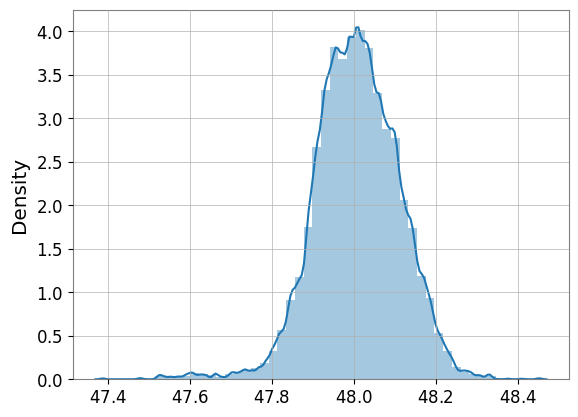

In [25]:
import seaborn as sns
sns.distplot(DL)

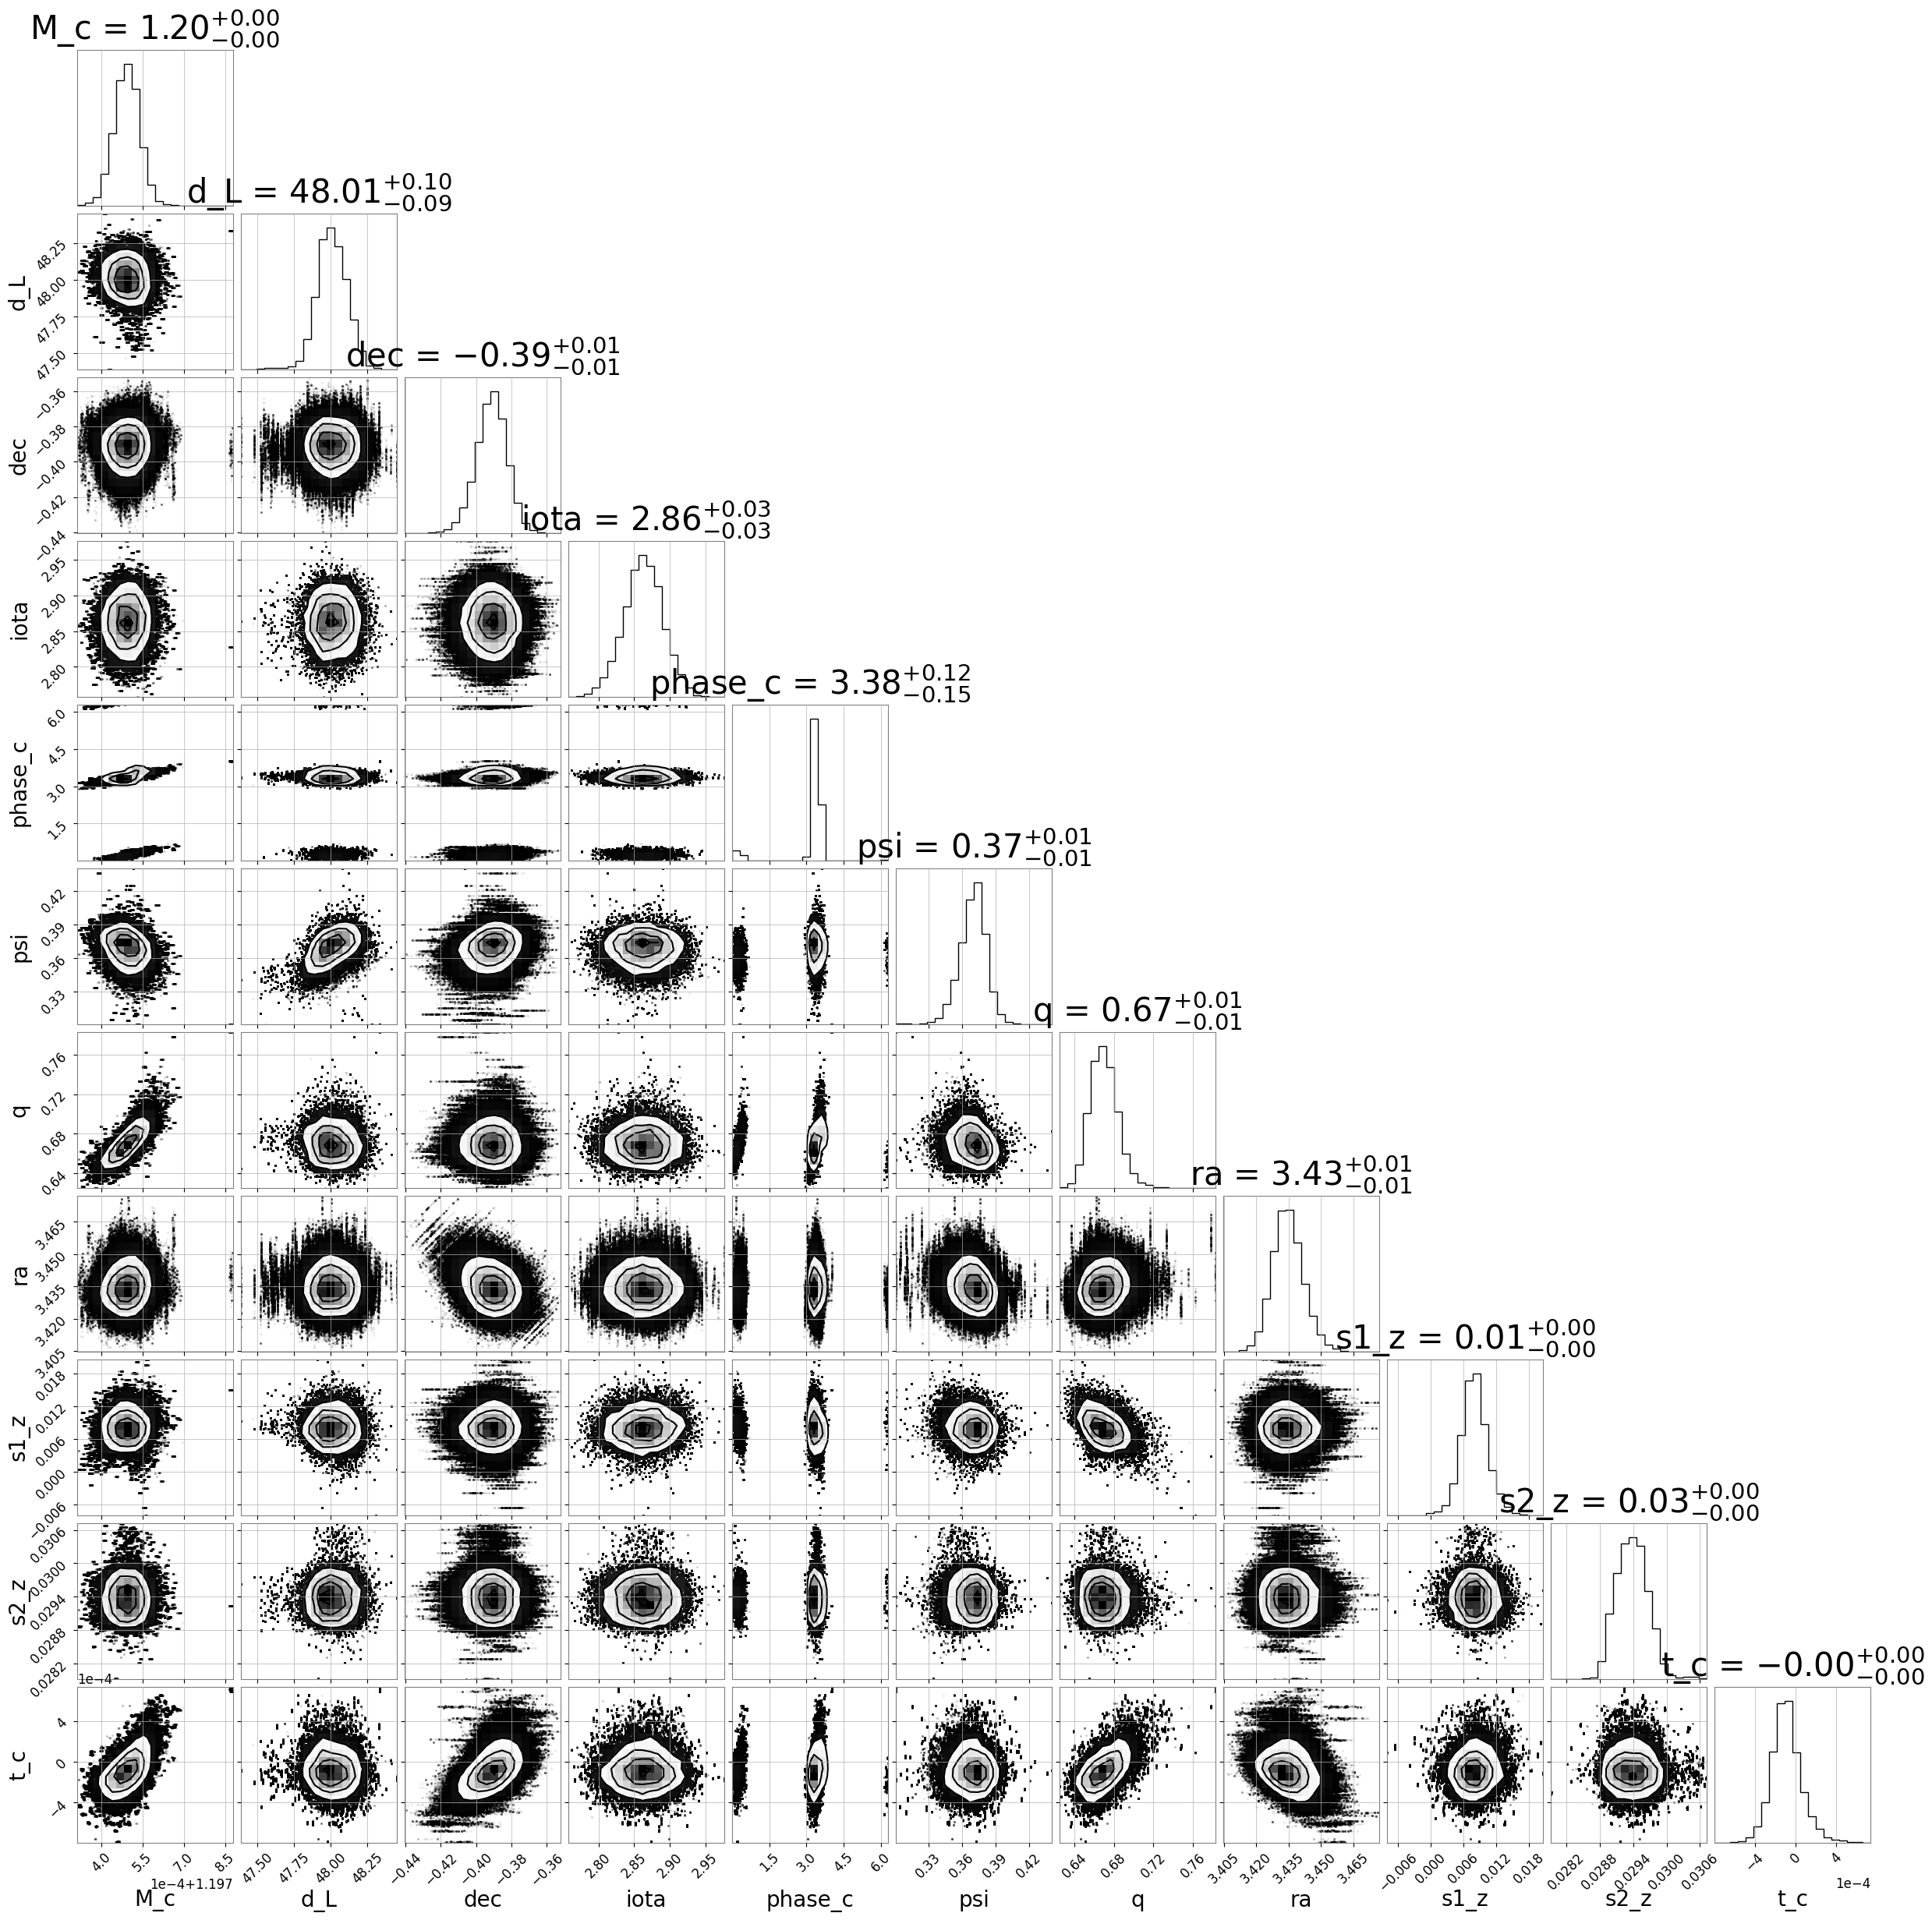

In [26]:
import corner
import numpy as np
import matplotlib.pyplot as plt
data = np.vstack([value for value in samples.values()]).T

# Create corner plot
fig = corner.corner(data, labels=list(samples.keys()),title_kwargs={'fontsize': 30},  # Increase title font size
    label_kwargs={'fontsize': 20}, show_titles=True)
plt.savefig("GW170817_GR_11_PARAM_manual_data_lambda.pdf")
# Show the plot
plt.show()

In [27]:
jim.print_summary()

Training summary
M_c: 1.197 +/- 0.003
d_L: 48.187 +/- 0.095
dec: -0.387 +/- 0.074
iota: 2.853 +/- 0.029
phase_c: 2.950 +/- 1.577
psi: 0.314 +/- 0.020
q: 0.641 +/- 0.159
ra: 3.426 +/- 0.140
s1_z: 0.010 +/- 0.003
s2_z: 0.029 +/- 0.000
t_c: -0.002 +/- 0.021
Log probability: -356.071 +/- 1647.010
Local acceptance: 0.361 +/- 0.480
Global acceptance: 0.002 +/- 0.044
Max loss: 21.893, Min loss: 6.271
Production summary
M_c: 1.197 +/- 0.000
d_L: 48.008 +/- 0.103
dec: -0.391 +/- 0.009
iota: 2.863 +/- 0.027
phase_c: 3.159 +/- 0.836
psi: 0.370 +/- 0.012
q: 0.670 +/- 0.014
ra: 3.435 +/- 0.007
s1_z: 0.008 +/- 0.002
s2_z: 0.029 +/- 0.000
t_c: -0.000 +/- 0.000
Log probability: 2.572 +/- 4.129
Local acceptance: 0.246 +/- 0.431
Global acceptance: 0.000 +/- 0.017


In [28]:
import numpy as np
import arviz as az



# Step 1: Reshape the samples to simulate multiple chains (assuming 2 chains)
# We split the long array into 2 chains. Adjust the shape as needed.
num_chains = 2
num_iterations = len(samples['M_c']) // num_chains  # Total samples / number of chains

samples_reshaped = {param: np.reshape(sample, (num_chains, num_iterations)) for param, sample in samples.items()}

# Step 2: Convert to Arviz InferenceData format
inference_data = az.from_dict(posterior=samples_reshaped)

# Step 3: Calculate Gelman-Rubin (Rhat)
rhat_values = az.rhat(inference_data)
print("Gelman-Rubin (Rhat) Values:\n", rhat_values)

# Step 4: Calculate Effective Sample Size (ESS)
ess_values = az.ess(inference_data)
print("\nEffective Sample Size (ESS):\n", ess_values)

# Optional: Visualize trace and autocorrelation plots
# az.plot_trace(inference_data)
# az.plot_autocorr(inference_data)


Gelman-Rubin (Rhat) Values:
 <xarray.Dataset> Size: 88B
Dimensions:  ()
Data variables:
    M_c      float64 8B 1.0
    d_L      float64 8B 1.0
    dec      float64 8B 1.0
    iota     float64 8B 1.0
    phase_c  float64 8B 1.001
    psi      float64 8B 1.001
    q        float64 8B 1.001
    ra       float64 8B 1.0
    s1_z     float64 8B 1.0
    s2_z     float64 8B 1.0
    t_c      float64 8B 1.0

Effective Sample Size (ESS):
 <xarray.Dataset> Size: 88B
Dimensions:  ()
Data variables:
    M_c      float64 8B 7.964e+03
    d_L      float64 8B 7.697e+03
    dec      float64 8B 1.098e+04
    iota     float64 8B 7.56e+03
    phase_c  float64 8B 8.01e+03
    psi      float64 8B 8.012e+03
    q        float64 8B 7.991e+03
    ra       float64 8B 1.117e+04
    s1_z     float64 8B 7.733e+03
    s2_z     float64 8B 7.445e+03
    t_c      float64 8B 7.794e+03


In [29]:
samples

{'M_c': Array([1.19745456, 1.19745615, 1.1974574 , ..., 1.19748049,
        1.19748049, 1.19748049], dtype=float64),
 'd_L': Array([47.96116656, 47.96116661, 47.96116661, ..., 47.95646112,
        47.95646112, 47.95646112], dtype=float64),
 'dec': Array([-0.3952363 , -0.3931668 , -0.39175607, ..., -0.38439725,
        -0.38439725, -0.38439725], dtype=float64),
 'iota': Array([2.86445422, 2.86445622, 2.8644528 , ..., 2.91473675,
        2.91473675, 2.91473675], dtype=float64),
 'phase_c': Array([3.29363979, 3.29614103, 3.29789371, ..., 3.39095554,
        3.39095554, 3.39095554], dtype=float64),
 'psi': Array([0.36468373, 0.36468356, 0.36468295, ..., 0.38652506,
        0.38652506, 0.38652506], dtype=float64),
 'q': Array([0.65381886, 0.6538148 , 0.65382199, ..., 0.65789503,
        0.65789503, 0.65789503], dtype=float64),
 'ra': Array([3.41848846, 3.42023083, 3.42141502, ..., 3.42462989,
        3.42462989, 3.42462989], dtype=float64),
 's1_z': Array([0.00966574, 0.00966586, 0.00966579

In [30]:
i = 0  # index of the sample to extract

ef_params = {
    'M_c': samples['M_c'][i],
    'd_L': samples['d_L'][i],
    'dec': samples['dec'][i],
    'iota': samples['iota'][i],
    'phase_c': samples['phase_c'][i],
    'psi': samples['psi'][i],
    'ra': samples['ra'][i],
    's1_z': samples['s1_z'][i],
    's2_z': samples['s2_z'][i],
    't_c': samples['t_c'][i],

    # Derived or custom values
    'eta': samples['q'][i] / (1 + samples['q'][i])**2,  # optional: compute symmetric mass ratio
    'alpha': 0.0,
    'beta': 0.0,
    'alphaB': 0.0
}


In [31]:
ef_params

{'M_c': Array(1.19745456, dtype=float64),
 'd_L': Array(47.96116656, dtype=float64),
 'dec': Array(-0.3952363, dtype=float64),
 'iota': Array(2.86445422, dtype=float64),
 'phase_c': Array(3.29363979, dtype=float64),
 'psi': Array(0.36468373, dtype=float64),
 'ra': Array(3.41848846, dtype=float64),
 's1_z': Array(0.00966574, dtype=float64),
 's2_z': Array(0.02939676, dtype=float64),
 't_c': Array(-0.00011907, dtype=float64),
 'eta': Array(0.23904605, dtype=float64),
 'alpha': 0.0,
 'beta': 0.0,
 'alphaB': 0.0}